In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
def analyze(forward_work, reverse_work, dir_num, phase, output_dir): 
    # Substract offset
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_work_offset, reverse_work_offset)
    
    # Plot work trajectories
    for cycle in forward_work_offset:
        x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ps)")
    plt.ylabel("work (kT)")
    plt.title(f"{pairs[dir_num][0]} -> {pairs[dir_num][1]} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    plt.clf()
    
    # Plot work distributions
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{pairs[dir_num][0]} -> {pairs[dir_num][1]} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    plt.clf()
    
    # Compute free energy 
    return dg, ddg
    

(5.970786138861276, 0.0007518662912796593)

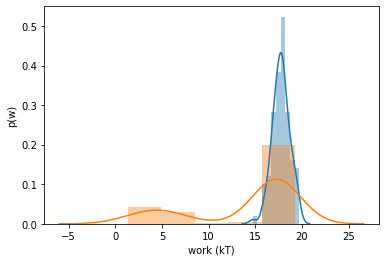

In [14]:
# Example use of analyze()

forward_solvent_path = '/data/chodera/zhangi/perses_benchmark/neq/old/0/solvent/0_forward.npy'
reverse_solvent_path = '/data/chodera/zhangi/perses_benchmark/neq/old/0/solvent/0_reverse.npy'

forward_vacuum_path = '/data/chodera/zhangi/perses_benchmark/neq/old/0/vacuum/0_forward.npy'
forward_vacuum_path = '/data/chodera/zhangi/perses_benchmark/neq/old/0/vacuum/0_reverse.npy'

# Load arrays
with open(forward_solvent_path, 'rb') as f:
    forward_work = np.load(f)

with open(reverse_solvent_path, 'rb') as f:
    reverse_work = np.load(f)
analyze(forward_work, reverse_work, 0, 'solvent', os.path.dirname(forward_solvent_path))

## Use new sim data (after dir structure reorg and re-generating htfs and saving trajs)

In [6]:
# Global variables
amino_acids = ['ALA', 'CYS', 'SER', 'THR']

# Create list of tuples for every pair of amino acids
pairs = list(itertools.permutations(amino_acids, r=2))

In [4]:
# Prep work arrays (from distributed jobs) and call analyze()
d_results = {}
for i in tqdm_notebook(range(12)):
    if i != 2:
        print(f"dir: {i}")
        # Load and combine arrays
        forward_solvent_arrays = []
        reverse_solvent_arrays = []
        forward_vacuum_arrays = []
        reverse_vacuum_arrays = []
        for j in tqdm_notebook(range(10)):
            print(f"job: {j}")
            forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_forward.npy'
            reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_reverse.npy'
            forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_forward.npy'
            reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_reverse.npy'
            if os.path.exists(forward_solvent_path):
                with open(forward_solvent_path, 'rb') as f:
                    forward_solvent_arrays.append(np.load(f))
            if os.path.exists(reverse_solvent_path):
                with open(reverse_solvent_path, 'rb') as f:
                    reverse_solvent_arrays.append(np.load(f))
            if os.path.exists(forward_vacuum_path):
                with open(forward_vacuum_path, 'rb') as f:
                    forward_vacuum_arrays.append(np.load(f))
            if os.path.exists(reverse_vacuum_path):
                with open(reverse_vacuum_path, 'rb') as f:
                    reverse_vacuum_arrays.append(np.load(f))
        if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
            forward_solvent_combined = np.concatenate(forward_solvent_arrays)
            reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
            forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
            reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)

            # Analyze
            solvent_dg, solvent_ddg = analyze(forward_solvent_combined, reverse_solvent_combined, i, 'solvent', os.path.dirname(forward_solvent_path))
            vacuum_dg, vacuum_ddg = analyze(forward_vacuum_combined, reverse_vacuum_combined, i, 'vacuum', os.path.dirname(forward_vacuum_path))
            solvation_dg = vacuum_dg - solvent_dg
            solvation_ddg = (vacuum_ddg**2 + solvent_ddg**2)**0.5
            d_results[pairs[i]] = [solvation_dg, solvation_ddg]
            print(f"vacuum dg: {vacuum_dg}, solvent_dg: {solvent_dg}")
        else:
            print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


dir: 0


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 4.749003623939881, solvent_dg: 6.578259383575328
dir: 1


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 9.54146396671964, solvent_dg: 7.76901473296733
dir: 3


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -4.801120400720513, solvent_dg: -6.591389847952169
dir: 4


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -5.010478768011138, solvent_dg: -7.386669919959484
dir: 5


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 9.77339692700088, solvent_dg: 7.37269711448643
dir: 6


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -9.41689152449264, solvent_dg: -9.362073795752007
dir: 7


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 4.940941484115028, solvent_dg: 7.33537475986004
dir: 8


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 13.859437213302977, solvent_dg: 13.583594210995331
dir: 9


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -23.327077393705757, solvent_dg: -21.688280831477105
dir: 10


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -7.007416308513394, solvent_dg: -5.227739339610647
dir: 11


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -10.984096164975663, solvent_dg: -11.073489790735586



<Figure size 432x288 with 0 Axes>

In [5]:
d_results

{('ALA', 'CYS'): [-1.8292557596354468, 0.0010610280757047366],
 ('ALA', 'SER'): [1.77244923375231, 0.0009016137218107477],
 ('CYS', 'ALA'): [1.7902694472316565, 0.0010562469462769516],
 ('CYS', 'SER'): [2.376191151948346, 0.0008945467529677441],
 ('CYS', 'THR'): [2.40069981251445, 0.0006604866899912095],
 ('SER', 'ALA'): [-0.05481772874063218, 0.0008744213713120721],
 ('SER', 'CYS'): [-2.394433275745012, 0.0008818676066682503],
 ('SER', 'THR'): [0.2758430023076457, 0.0008176260779898922],
 ('THR', 'ALA'): [-1.6387965622286522, 0.0007157708748380432],
 ('THR', 'CYS'): [-1.7796769689027467, 0.0005906595518080168],
 ('THR', 'SER'): [0.08939362575992327, 0.0007900136450220111]}

In [6]:
d_results[('ALA', 'THR')] = [np.nan, np.nan]

In [7]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/3/d_results.pickle", "wb") as f:
    pickle.dump(d_results, f)

In [3]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/3/d_results.pickle", "rb") as f:
    d_results = pickle.load(f)

In [8]:
# Format to match Dominic's table
d_combined = {}
rows = [('ALA', 'SER'), ('ALA', 'CYS'), ('ALA', 'THR'), ('SER', 'CYS'), ('SER', 'THR'), ('CYS', 'THR')]
for pair, (dg, ddg) in sorted(d_results.items()):
    if pair in rows:
        d_combined[pair] = [dg, ddg]

for pair, (dg, ddg) in sorted(d_results.items()):
    if pair not in d_combined:
        reversed_pair = pair[::-1]
        forward_solvation_dg = d_combined[reversed_pair][0]
        forward_solvation_ddg = d_combined[reversed_pair][1]
        d_combined[reversed_pair] += [dg, ddg, abs(forward_solvation_dg) - abs(dg), abs(forward_solvation_ddg) - abs(ddg)]



In [9]:
# Create dataframe
df = pd.DataFrame.from_dict(d_combined, orient='index', columns=['forward solvation dG', 
                                                            'forward solvation ddG', 
                                                            'reverse solvation dG',
                                                            'reverse solvation ddG',
                                                            'discrepancy dG',
                                                            'discrepancy ddG'
                                                           ]
                      
                      )

In [10]:
df.reindex(index=rows)

,forward solvation dG,forward solvation ddG,reverse solvation dG,reverse solvation ddG,discrepancy dG,discrepancy ddG
"(ALA, SER)",1.772449,0.000902,-0.054818,0.000874,1.717632,0.000027
"(ALA, CYS)",-1.829256,0.001061,1.790269,0.001056,0.038986,0.000005
"(ALA, THR)",NaN,NaN,-1.638797,0.000716,NaN,NaN
"(SER, CYS)",-2.394433,0.000882,2.376191,0.000895,0.018242,-0.000013
"(SER, THR)",0.275843,0.000818,0.089394,0.000790,0.186449,0.000028
"(CYS, THR)",2.400700,0.000660,-1.779677,0.000591,0.621023,0.000070


### Get indices of trajectories to look at in pymol

In [2]:
# Get works

i = 10
# Load and combine arrays
forward_solvent_arrays = []
reverse_solvent_arrays = []
forward_vacuum_arrays = []
reverse_vacuum_arrays = []
for j in tqdm_notebook(range(10)):
    print(f"job: {j}")
    forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_forward.npy'
    reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_reverse.npy'
    forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_forward.npy'
    reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_reverse.npy'
    if os.path.exists(forward_solvent_path):
        with open(forward_solvent_path, 'rb') as f:
            forward_solvent_arrays.append(np.load(f))
    if os.path.exists(reverse_solvent_path):
        with open(reverse_solvent_path, 'rb') as f:
            reverse_solvent_arrays.append(np.load(f))
    if os.path.exists(forward_vacuum_path):
        with open(forward_vacuum_path, 'rb') as f:
            forward_vacuum_arrays.append(np.load(f))
    if os.path.exists(reverse_vacuum_path):
        with open(reverse_vacuum_path, 'rb') as f:
            reverse_vacuum_arrays.append(np.load(f))
if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
    forward_solvent_combined = np.concatenate(forward_solvent_arrays)
    reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
    forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
    reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)


# Substract offset
forward_work_offset = []
for cycle in forward_solvent_combined:
    forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset = np.array(forward_work_offset)

reverse_work_offset = []
for cycle in reverse_solvent_combined:
    reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
reverse_work_offset = np.array(reverse_work_offset)


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9



In [38]:
### i = 10, near middle of trajectory (35 ps)
### Important numbers: 3rd and 5th numbers
# labels:
## i - cycle number (0-indexed)
## int(i/10) -- pdb number (0-indexed)
## i%10 + 1 -- index of cycle in pdb (between 1-10)
## (i%10 + 1)*2 -1 -- index of frame *before switch* in pdb (between 1-20)
for i, cycle in enumerate(reverse_work_offset):
    if cycle[8750] > -18:
        print("> -18", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1, cycle[8750])

for i, cycle in enumerate(reverse_work_offset):
    if cycle[8750] < -23:
        print("< -23", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1 , cycle[8750])

> -18 3 0 4 7 -17.939688888623465
> -18 11 1 2 3 -17.528974225762035
> -18 31 3 2 3 -17.457932692475808
> -18 33 3 4 7 -17.300710305540406
> -18 37 3 8 15 -17.885845156598343
> -18 52 5 3 5 -17.877561411167513
> -18 53 5 4 7 -17.507511123480462
> -18 68 6 9 17 -17.407572956020754
> -18 90 9 1 1 -17.342339314011987
> -18 98 9 9 17 -17.925739531657857
< -23 10 1 1 1 -24.013704958468015
< -23 15 1 6 11 -24.949798314796087
< -23 16 1 7 13 -23.267022778584675
< -23 38 3 9 17 -24.630337012957195
< -23 39 3 10 19 -23.47016037995317
< -23 41 4 2 3 -24.853442622908467


In [12]:
### i = 10, near middle of trajectory (35 ps)
# labels:
## i - cycle number (0-indexed)
## int(i/10) -- pdb number (0-indexed)
## i%10 + 1 -- index of cycle in pdb (between 1-10)
## (i%10 + 1)*2 -1 -- index of frame *before switch* in pdb (between 1-20)
for i, cycle in enumerate(forward_work_offset):
    if cycle[8750] > -26:
        print("> -26", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1, cycle[8750])

for i, cycle in enumerate(forward_work_offset):
    if cycle[8750] < -33:
        print("< -33", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1 , cycle[8750])

> -26 10 1 1 1 -24.857928462314348
> -26 11 1 2 3 -25.15615432073608
> -26 15 1 6 11 -24.24534757345779
> -26 16 1 7 13 -24.030377077043664
> -26 21 2 2 3 -25.440650300509517
> -26 38 3 9 17 -25.828783734361114
> -26 57 5 8 15 -25.51637633937472
> -26 63 6 4 7 -25.9050409677802
> -26 93 9 4 7 -24.667708221409967
< -33 0 0 1 1 -33.04863787299388
< -33 8 0 9 17 -33.36708789641448
< -33 13 1 4 7 -33.448390704444954
< -33 22 2 3 5 -33.833707257096044
< -33 26 2 7 13 -33.66315385852354
< -33 34 3 5 9 -34.19161149104983
< -33 37 3 8 15 -34.07548666346302
< -33 48 4 9 17 -33.03144379979973
< -33 56 5 7 13 -33.432686905892545
< -33 85 8 6 11 -34.974093304949264
< -33 97 9 8 15 -33.10744975053416


In [31]:
### i = 0, near start of trajectory (20 ps)
# labels:
## i - cycle number (0-indexed)
## int(i/10) -- pdb number (0-indexed)
## i%10 + 1 -- index of cycle in pdb (between 1-10)
## (i%10 + 1)*2 -1 -- index of frame *before switch* in pdb (between 1-20)
for i, cycle in enumerate(reverse_work_offset):
    if cycle[5000] > -1:
        print("> -1", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1, cycle[5000])

for i, cycle in enumerate(reverse_work_offset):
    if cycle[5000] < -7.5:
        print("< -7.5", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1 , cycle[5000])

> -1 47 4 8 15 -0.8811622584317398
> -1 51 5 2 3 -0.9694523470069285
> -1 81 8 2 3 -0.9052387111551958
> -1 92 9 3 5 -0.9712696058926191
> -1 99 9 10 19 -0.4250283120153675
< -7.5 8 0 9 17 -7.597717676191866
< -7.5 12 1 3 5 -7.63847623590612
< -7.5 48 4 9 17 -7.559350907114075
< -7.5 64 6 5 9 -7.621000597869536


In [30]:
### i = 1, end of trajectory
# labels:
## i - cycle number (0-indexed)
## int(i/10) -- pdb number (0-indexed)
## i%10 + 1 -- index of cycle in pdb (between 1-10)
## (i%10 + 1)*2 -1 -- index of frame *before switch* in pdb (between 1-20)
for i, cycle in enumerate(reverse_work_offset):
    if cycle[-1] > -4:
        print("> -4", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1, cycle[-1])

for i, cycle in enumerate(reverse_work_offset):
    if cycle[-1] < -22:
        print("< -22", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1 , cycle[-1])

> -4 2 0 3 5 -0.664950891271566
> -4 33 3 4 7 -1.837155218293038
> -4 43 4 4 7 -2.339668456201604
> -4 73 7 4 7 -1.1851652590436252
> -4 74 7 5 9 -0.7033103976879005
> -4 87 8 8 15 -0.542799464755479
< -22 21 2 2 3 -22.763016279728316
< -22 53 5 4 7 -23.183369965602573
< -22 58 5 9 17 -22.005155057755555
< -22 63 6 4 7 -22.152391565632964
< -22 67 6 8 15 -24.029626966858885
< -22 69 6 10 19 -23.011844486446808


In [43]:
### i = 1, near start of trajectory (20 ps)
# labels:
## i - cycle number (0-indexed)
## int(i/10) -- pdb number (0-indexed)
## i%10 + 1 -- index of cycle in pdb (between 1-10)
## (i%10 + 1)*2 -1 -- index of frame *before switch* in pdb (between 1-20)
for i, cycle in enumerate(reverse_work_offset):
    if cycle[5000] > 4:
        print("> 4", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1, cycle[5000])

for i, cycle in enumerate(reverse_work_offset):
    if cycle[5000] < -10:
        print("< -10", i, int(i/10), i%10 + 1, (i%10 + 1)*2 -1 , cycle[5000])

> 4 10 1 1 1 4.8080142751021135
> 4 40 4 1 1 4.136433544445303
> 4 43 4 4 7 4.834187541895364
> 4 49 4 10 19 4.043142589060761
> 4 74 7 5 9 4.091278009304833
< -10 3 0 4 7 -10.30253128965199
< -10 4 0 5 9 -10.200137960071856
< -10 9 0 10 19 -10.135936905875134
< -10 21 2 2 3 -10.481097675797674
< -10 26 2 7 13 -10.267068943016644
< -10 37 3 8 15 -10.21454869268256
< -10 53 5 4 7 -10.405692339795104
< -10 64 6 5 9 -10.09146849001687
< -10 65 6 6 11 -10.29529708377428
< -10 67 6 8 15 -10.912256783135518
< -10 80 8 1 1 -10.616980484788744
< -10 92 9 3 5 -10.230546023766276


## Use new sim data (after dir structure reorg and regenerating htfs and saving trajs) -- non-default electrostatics protocol

In [11]:
# Prep work arrays (from distributed jobs) and call analyze()
d_results = {}
for i in tqdm_notebook(range(12)):
    if i != 2:
        print(f"dir: {i}")
        # Load and combine arrays
        forward_solvent_arrays = []
        reverse_solvent_arrays = []
        forward_vacuum_arrays = []
        reverse_vacuum_arrays = []
        for j in tqdm_notebook(range(10)):
            print(f"job: {j}")
            forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_solvent_{j}_forward.npy'
            reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_solvent_{j}_reverse.npy'
            forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_vacuum_{j}_forward.npy'
            reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_vacuum_{j}_reverse.npy'
            if os.path.exists(forward_solvent_path):
                with open(forward_solvent_path, 'rb') as f:
                    forward_solvent_arrays.append(np.load(f))
            if os.path.exists(reverse_solvent_path):
                with open(reverse_solvent_path, 'rb') as f:
                    reverse_solvent_arrays.append(np.load(f))
            if os.path.exists(forward_vacuum_path):
                with open(forward_vacuum_path, 'rb') as f:
                    forward_vacuum_arrays.append(np.load(f))
            if os.path.exists(reverse_vacuum_path):
                with open(reverse_vacuum_path, 'rb') as f:
                    reverse_vacuum_arrays.append(np.load(f))
        if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
            forward_solvent_combined = np.concatenate(forward_solvent_arrays)
            reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
            forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
            reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)

            # Analyze
            solvent_dg, solvent_ddg = analyze(forward_solvent_combined, reverse_solvent_combined, i, 'solvent', os.path.dirname(forward_solvent_path))
            vacuum_dg, vacuum_ddg = analyze(forward_vacuum_combined, reverse_vacuum_combined, i, 'vacuum', os.path.dirname(forward_vacuum_path))
            solvation_dg = vacuum_dg - solvent_dg
            solvation_ddg = (vacuum_ddg**2 + solvent_ddg**2)**0.5
            d_results[pairs[i]] = [solvation_dg, solvation_ddg]
            print(f"vacuum dg: {vacuum_dg}, solvent_dg: {solvent_dg}")
        else:
            print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


dir: 0


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 4.242316079248315, solvent_dg: 6.747023941386586
dir: 1


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 9.294305356673364, solvent_dg: 8.82211975781065
dir: 3


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -5.125268717552064, solvent_dg: -6.897185294212881
dir: 4


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -4.4808790077284435, solvent_dg: -7.089511319148493
dir: 5


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 8.722584360117697, solvent_dg: 8.075577712969432
dir: 6


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -9.113622549081867, solvent_dg: -7.5862502692892075
dir: 7


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 5.081322858627801, solvent_dg: 7.5584988266853195
dir: 8


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: 13.855490965198356, solvent_dg: 13.875292357937527
dir: 9


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -23.44987908599584, solvent_dg: -21.407968155641374
dir: 10


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -6.609961661559313, solvent_dg: -3.9302710400954353
dir: 11


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9

vacuum dg: -9.961060230758926, solvent_dg: -11.697671612143298



<Figure size 432x288 with 0 Axes>

In [12]:
d_results

{('ALA', 'CYS'): [-2.504707862138271, 0.0012863859679359915],
 ('ALA', 'SER'): [0.4721855988627137, 0.001255241270899792],
 ('CYS', 'ALA'): [1.771916576660817, 0.0008148368400353324],
 ('CYS', 'SER'): [2.60863231142005, 0.0007877363416164383],
 ('CYS', 'THR'): [0.647006647148265, 0.001014477580280241],
 ('SER', 'ALA'): [-1.5273722797926599, 0.0005689991000766275],
 ('SER', 'CYS'): [-2.4771759680575185, 0.0009358507153477856],
 ('SER', 'THR'): [-0.019801392739170254, 0.0011610970266156281],
 ('THR', 'ALA'): [-2.041910930354465, 0.0003800356285358927],
 ('THR', 'CYS'): [-2.679690621463878, 0.00029055838350033555],
 ('THR', 'SER'): [1.736611381384371, 0.00045915041294779143]}

In [15]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/2/d_results.pickle", "wb") as f:
    pickle.dump(d_results, f)

In [3]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/2/d_results.pickle", "rb") as f:
    d_results = pickle.load(f)

In [14]:
d_results[('ALA', 'THR')] = [np.nan, np.nan]

In [16]:
# Format to match Dominic's table
d_combined = {}
rows = [('ALA', 'SER'), ('ALA', 'CYS'), ('ALA', 'THR'), ('SER', 'CYS'), ('SER', 'THR'), ('CYS', 'THR')]
for pair, (dg, ddg) in sorted(d_results.items()):
    if pair in rows:
        d_combined[pair] = [dg, ddg]

for pair, (dg, ddg) in sorted(d_results.items()):
    if pair not in d_combined:
        reversed_pair = pair[::-1]
        forward_solvation_dg = d_combined[reversed_pair][0]
        forward_solvation_ddg = d_combined[reversed_pair][1]
        d_combined[reversed_pair] += [dg, ddg, abs(forward_solvation_dg) - abs(dg), abs(forward_solvation_ddg) - abs(ddg)]



In [17]:
# Create dataframe
df = pd.DataFrame.from_dict(d_combined, orient='index', columns=['forward solvation dG', 
                                                            'forward solvation ddG', 
                                                            'reverse solvation dG',
                                                            'reverse solvation ddG',
                                                            'discrepancy dG',
                                                            'discrepancy ddG'
                                                           ]
                      
                      )

In [18]:
df.reindex(index=rows)

,forward solvation dG,forward solvation ddG,reverse solvation dG,reverse solvation ddG,discrepancy dG,discrepancy ddG
"(ALA, SER)",0.472186,0.001255,-1.527372,0.000569,-1.055187,0.000686
"(ALA, CYS)",-2.504708,0.001286,1.771917,0.000815,0.732791,0.000472
"(ALA, THR)",NaN,NaN,-2.041911,0.000380,NaN,NaN
"(SER, CYS)",-2.477176,0.000936,2.608632,0.000788,-0.131456,0.000148
"(SER, THR)",-0.019801,0.001161,1.736611,0.000459,-1.716810,0.000702
"(CYS, THR)",0.647007,0.001014,-2.679691,0.000291,-2.032684,0.000724


## Plot forward work distributions for default vs sqrt electrostatics

In [3]:
# Get works for ALA -> SER (default protocol)

i = 1 # (ALA -> SER)
# Load and combine arrays
forward_solvent_arrays = []
reverse_solvent_arrays = []
forward_vacuum_arrays = []
reverse_vacuum_arrays = []
for j in tqdm_notebook(range(10)):
    print(f"job: {j}")
    forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_forward.npy'
    reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_solvent_{j}_reverse.npy'
    forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_forward.npy'
    reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/3/{i}/{i}_vacuum_{j}_reverse.npy'
    if os.path.exists(forward_solvent_path):
        with open(forward_solvent_path, 'rb') as f:
            forward_solvent_arrays.append(np.load(f))
    if os.path.exists(reverse_solvent_path):
        with open(reverse_solvent_path, 'rb') as f:
            reverse_solvent_arrays.append(np.load(f))
    if os.path.exists(forward_vacuum_path):
        with open(forward_vacuum_path, 'rb') as f:
            forward_vacuum_arrays.append(np.load(f))
    if os.path.exists(reverse_vacuum_path):
        with open(reverse_vacuum_path, 'rb') as f:
            reverse_vacuum_arrays.append(np.load(f))
if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
    forward_solvent_combined = np.concatenate(forward_solvent_arrays)
    reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
    forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
    reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)


# Substract offset
forward_work_offset_sol = []
for cycle in forward_solvent_combined:
    forward_work_offset_sol.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_sol = np.array(forward_work_offset_sol)

forward_work_offset_vac = []
for cycle in forward_vacuum_combined:
    forward_work_offset_vac.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_vac = np.array(forward_work_offset_vac)


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9



In [4]:
# Get works for ALA -> SER (sqrt protocol)

i = 1 # (ALA -> SER)
# Load and combine arrays
forward_solvent_arrays = []
reverse_solvent_arrays = []
forward_vacuum_arrays = []
reverse_vacuum_arrays = []
for j in tqdm_notebook(range(10)):
    print(f"job: {j}")
    forward_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_solvent_{j}_forward.npy'
    reverse_solvent_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_solvent_{j}_reverse.npy'
    forward_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_vacuum_{j}_forward.npy'
    reverse_vacuum_path = f'/data/chodera/zhangi/perses_benchmark/neq/2/{i}/{i}_vacuum_{j}_reverse.npy'
    if os.path.exists(forward_solvent_path):
        with open(forward_solvent_path, 'rb') as f:
            forward_solvent_arrays.append(np.load(f))
    if os.path.exists(reverse_solvent_path):
        with open(reverse_solvent_path, 'rb') as f:
            reverse_solvent_arrays.append(np.load(f))
    if os.path.exists(forward_vacuum_path):
        with open(forward_vacuum_path, 'rb') as f:
            forward_vacuum_arrays.append(np.load(f))
    if os.path.exists(reverse_vacuum_path):
        with open(reverse_vacuum_path, 'rb') as f:
            reverse_vacuum_arrays.append(np.load(f))
if forward_solvent_arrays and reverse_solvent_arrays and forward_vacuum_arrays and reverse_vacuum_arrays:
    forward_solvent_combined = np.concatenate(forward_solvent_arrays)
    reverse_solvent_combined = np.concatenate(reverse_solvent_arrays)
    forward_vacuum_combined = np.concatenate(forward_vacuum_arrays)
    reverse_vacuum_combined = np.concatenate(reverse_vacuum_arrays)


# Substract offset
forward_work_offset_sol_2 = []
for cycle in forward_solvent_combined:
    forward_work_offset_sol_2.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_sol_2 = np.array(forward_work_offset_sol_2)

forward_work_offset_vac_2 = []
for cycle in forward_solvent_combined:
    forward_work_offset_vac_2.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_vac_2 = np.array(forward_work_offset_vac_2)


/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9



Text(0.5, 1.0, 'ALA -> SER solvent')

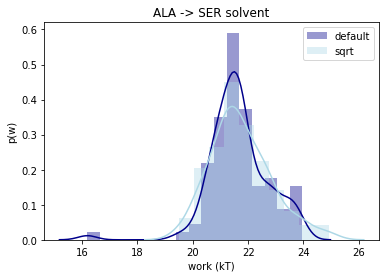

In [22]:
# Plot forward work distributions for solvent
accumulated_forward_sol = [cycle[-1] for cycle in forward_work_offset_sol]
sns.distplot(accumulated_forward_sol, color='darkblue', label='default')
accumulated_forward_sol_2 = [cycle[-1] for cycle in forward_work_offset_sol_2]
sns.distplot(accumulated_forward_sol_2, color='lightblue', label='sqrt')
plt.legend(loc='best')
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.title(f"{pairs[1][0]} -> {pairs[1][1]} solvent")
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
# plt.clf()


Text(0.5, 1.0, 'ALA -> SER vacuum')

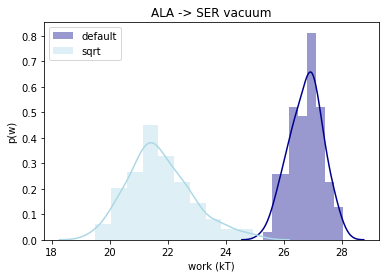

In [23]:
# Plot forward work distributions for vacuum
accumulated_forward_vac = [cycle[-1] for cycle in forward_work_offset_vac]
sns.distplot(accumulated_forward_vac, color='darkblue', label='default')
accumulated_forward_vac_2 = [cycle[-1] for cycle in forward_work_offset_vac_2]
sns.distplot(accumulated_forward_vac_2, color='lightblue', label='sqrt')
plt.legend(loc='best')
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.title(f"{pairs[1][0]} -> {pairs[1][1]} vacuum")
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
# plt.clf()


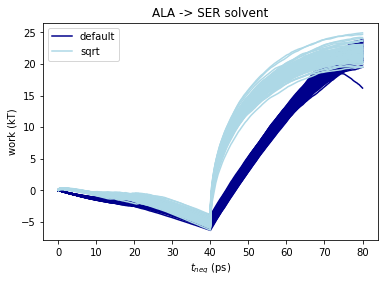

In [19]:
# Plot forward work trajectories for solvent
for i, cycle in enumerate(forward_work_offset_sol):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
        plt.plot(x, y, color='darkblue', label='default')
    else:
        plt.plot(x, y, color='darkblue')
for i, cycle in enumerate(forward_work_offset_sol_2):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
         plt.plot(x, y, color='lightblue', label='sqrt')
    else:
        plt.plot(x, y, color='lightblue')
plt.legend(loc='best')
plt.xlabel("$t_{neq}$ (ps)")
plt.ylabel("work (kT)")
plt.title(f"{pairs[1][0]} -> {pairs[1][1]} solvent")
plt.show()
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
# plt.clf()

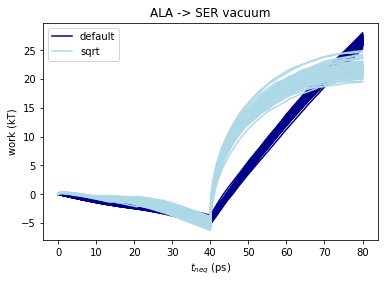

In [18]:
# Plot forward work trajectories for vacuum
for i, cycle in enumerate(forward_work_offset_vac):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
        plt.plot(x, y, color='darkblue', label='default')
    else:
        plt.plot(x, y, color='darkblue')
for i, cycle in enumerate(forward_work_offset_vac_2):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
         plt.plot(x, y, color='lightblue', label='sqrt')
    else:
        plt.plot(x, y, color='lightblue')
plt.legend(loc='best')
plt.xlabel("$t_{neq}$ (ps)")
plt.ylabel("work (kT)")
plt.title(f"{pairs[1][0]} -> {pairs[1][1]} vacuum")
plt.show()
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
# plt.clf()